<h1>Imports and setup</h1>

In [ ]:
from collections import defaultdict
import csv
import itertools
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import spearmanr

import vsm
import utils

In [2]:
utils.fix_random_seeds()

In [3]:
VSM_HOME = os.path.join('data', 'vsmdata')
DATA_HOME = os.path.join('data', 'wordrelatedness')

<h1>High level overview</h1>

This notebook tests two methods: a PPMI -> LSA -> Retrofitting pipeline, and the GloVe method. Our default was to start with the giga20 vsm provided, since this was used in the rest of assignment 1. 

The first pipeline is motivated by a few observations/tips from lecture:
* PPMI does very well at re-balancing the distribution of the data and is generally a simple but powerful technique, thus a good starting point.
* Dimensionality reduction can help capture higher-order features, and LSA remains a standard baseline; furthermore, the PPMI -> LSA order of application is common, due to the underlying mathematical assumptions of LSA.
* Retrofitting could help by essentially bringing in useful semantic info from another data source, eg. WordNet.
We thought it could be valid/useful to apply Retrofitting to the vsm that has already gone through PPMI and LSA (as opposed to applying Retrofitting to the raw count matrix) since Retrofitting does not make assumptions about the existing vsm $\hat{Q}$. Also, this is similar to how `vsm_03_retrofitting.ipynb` applies retrofitting to the transformed GloVe embedding space.

For both methods, we assume the default cosine distance function, since from `vsm_01_distributional.ipynb` this seems to consistently yield better results than the other distance functions.

In [4]:
dev_df = pd.read_csv(os.path.join(DATA_HOME, "cs224u-wordrelatedness-dev.csv"))
count_df = pd.read_csv(os.path.join(VSM_HOME, 'giga_window20-flat.csv.gz'), index_col=0)

When we noticed there was not a huge amount of improvement with the two methods above, we also did some trials where we used the yelp20 vsm, in an attempt to see if one was a better starting point than the other. A third idea was to combine the data from the underlying yelp and gigaword datasets. We combined these datasets by adding the giga20 and yelp20 raw count matrices together to form a `combined_df`. The hypothesis was that by leveraging more data in the underlying vsm, we could get better results. An alternative hypothesis is that the yelp data and gigaword data could look very different, hence leading to a weaker representation and worse results.

In [57]:
yelp_df = pd.read_csv(os.path.join(VSM_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)
combined_df = count_df + yelp_df
print(combined_df.shape) # sanity check this matrix addition

(6000, 6000)


<h1>Baseline: PPMI</h1>
We start constructing the PPMI -> LSA -> Retrofitting pipeline by profiling the first stage of the pipeline, PPMI. This section contains largely the same code as provided in assignment 1.

In [52]:
def apply_ppmi(df):
    return vsm.pmi(df)

def evaluate(df):
    pred_df, rho = vsm.word_relatedness_evaluation(dev_df, df)
    print(rho)
    return rho

def ppmi_model():
    pipeline = apply_ppmi(count_df)
    return pipeline

In [ ]:
ppmi = ppmi_model()
evaluate(ppmi) # 0.35078317826072747
evaluate(apply_ppmi(combined_df)) # 0.34506314450395015
evaluate(apply_ppmi(yelp_df)) # 0.2681669369260301

# vsm.tsne_viz(ppmi, output_filename=None, figsize=(40, 50), random_state=42)

PPMI on giga20 yielded a score of 0.351. It turns out that the yelp20 vsm led to a much lower score, and thus, the `combined_df` also had a lower score than giga20 alone. In the `vsm_01_distributional.ipynb` notebook, we used t-SNE to visualize the effect of PPMI on yelp20. Here, we attempted to also visualize the effect of PPMI on giga20, in order to compare and see if there are any differences that could explain why giga20 gave a much better score. However, we did not find any intuitive clues from the visualization.

<h1>PPMI - LSA</h1>
Next we add the LSA step to the pipeline. In the assignment, using a value of k=10 actually decreased the score compared to PPMI alone. So, here we evaluate the score of various values of k, in order to tune this hyperparameter.

In [ ]:
def apply_lsa(df, k):
    return vsm.lsa(df, k=k)

def ppmi_lsa_model(k):
    print(k)
    #ppmi = ppmi_model
    ppmi = apply_ppmi(count_df)
    pipeline = apply_lsa(ppmi, k)
    return pipeline

k_values = [55, 75] # See table below for complete set of k's we tried. 
for k in k_values:
    evaluate(ppmi_lsa_model(k=k))

Record of values of k tried and resulting rho:

| k | rho | 
| --- | --- |
|5  | 0.2690793493940406 |
|10 | 0.3188110541644582 |
|15 | 0.33787063311107074 |
|20 | 0.3494470390248065 |
|23 | 0.35493003920064664 |
|25 | 0.35801029120400735 |
|27 | 0.3605741064664968 |
|29 | 0.3634646054248036 |
|30 | 0.3641395062507528 |
|35 | 0.36595271827140213 |
|55 | 0.37361430680403135 |
|75 | 0.3780506404505552 |
|100 | 0.3804359519023298 |
|200 | 0.37933931313996916 |
|300 | 0.3704844541599484 |

Need k>=23 in order to have an improvement over PPMI baseline.

Plotted in below cell.

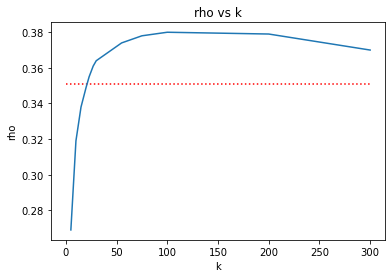

In [43]:
import matplotlib
import matplotlib.pyplot as plt

ks = [5, 10, 15, 20, 23, 25, 27, 29, 30, 35, 55, 75, 100, 200, 300]
rhos = [0.269, 0.319, 0.338, 0.349, 0.355, 0.358, 0.361, 0.363, 0.364, 0.366, 0.374, 0.378, 0.380, 0.379, 0.370]

fig, ax = plt.subplots()
ax.set(xlabel='k', ylabel='rho', title='rho vs k')
ax.plot(ks, rhos)
ax.hlines(0.351, 0, 300, colors='red', linestyles='dotted', label='ppmi')
plt.show()

Based on the above, choose k=100.

In [ ]:
# try for some combined dataset and yelp dataset
# for k in [25, 50, 100]:
#     evaluate(apply_lsa(apply_ppmi(combined_df), k))
#     evaluate(apply_lsa(apply_ppmi(yelp_df), k))

# results:
# 0.32397790824401773
# 0.273638229822923
# 0.3440280665365778
# 0.29190854734437527
# 0.3543426961440956
# (aborted yelp k=100)

We also tried the yelp20 and combined_df at this stage.

| data | k | score | 
| --- | --- | --- |
| combined | 25 | 0.32397790824401773 |
| yelp20 | 25 | 0.273638229822923 |
| combined | 50 | 0.3440280665365778 |
| yelp20 | 50 | 0.29190854734437527 |
| combined | 100 | 0.3543426961440956 |

The effect of k on the score seems to be consistent with when we used the giga20 data. Similar to the results from PPMI alone, the yelp20 dataset continues to perform significantly worse and the combined_df is also slightly worse than the giga20 vsm.

<h1>PPMI - LSA - Retrofit</h1>

After picking a value of k for LSA, we move onto adding a Retrofitting step. In short, we got very little improvements from Retrofitting, so at this point, we also started examining vsm.neighbors() to try to look into the effect of our transformations and understand why there is hardly an improvement in the score.

In [19]:
from nltk.corpus import wordnet as wn
import retrofitting
from retrofitting import Retrofitter

First, a sanity check to see how vsm.neighbors() is like on the PPMI-LSA pipeline so far. 

As a reference, here were the results from `vsm_01_distributional.ipynb`, for PPMI on giga20:
superb         0.000000
excellent      0.367458
perfect        0.374185
terrific       0.381038
beautifully    0.388652

In comparison, the neighbors of 'superb' are still the same but ~3x shorter distance from 'superb.' This suggests LSA helps our vsm captures more semantic similarity. However, this ~3x reduction in distance only translated to ~0.03 improvement in $\rho$. One realization is that in order to succeed at getting a good rho, we don't necessarily want our words to be similar by some absolute measure; instead, we need it to "match" the scoring scheme of the relatedness dataset. This might explain why the reduction in distance of similar vectors does not translate to the same improvement in the score.

<h3>An idea</h3>
This led to the idea: can we make better use of the dev_df such that it's incorporated into the transformations we perform on the vsm, and not just used to evaluate/choose hyperparameters? For example, one idea is to write something like get_dev_edges(), which uses the info in `dev_df` to generate an edge set for retrofitting. We could set some threshold, ex. assume that if annotated_score(word1, word2) > 0.5, then they are similar, and create an edge between those words. However we did not have time to implement and fully explore this approach. In addition, we also had concerns that this would lead to overfitting the dev set.

In [65]:
ppmi_lsa = ppmi_lsa_model(k=100)
print(ppmi_lsa.shape) # (6000, 100)
vsm.neighbors('superb', ppmi_lsa).head()

superb         0.000000
excellent      0.118194
terrific       0.138579
perfect        0.142211
beautifully    0.146424
dtype: float64

Now for the actual retrofitting.

In [20]:
# retrofit helper functions copied from notebook
def get_wordnet_edges():
    edges = defaultdict(set)
    for ss in wn.all_synsets():
        lem_names = {lem.name() for lem in ss.lemmas()}
        for lem in lem_names:
            edges[lem] |= lem_names
    return edges

def convert_edges_to_indices(edges, Q):
    lookup = dict(zip(Q.index, range(Q.shape[0])))
    index_edges = defaultdict(set)
    for start, finish_nodes in edges.items():
        s = lookup.get(start)
        if s:
            f = {lookup[n] for n in finish_nodes if n in lookup}
            if f:
                index_edges[s] = f
    return index_edges

We first tried using the default hyperparameters, then tried other values of alpha in the range of [0.25, 20]. (We didn't try different beta values because it's the relative weight of alpha vs beta that matters.) Generally, when $\alpha \leq 1$, smaller alpha means worse score. For larger values of alpha, the score improves then decreases again. At the end, the best value we found was alpha=10, which yielded a score of 0.381. Note though that this is only a tiny (almost negligible) improvement over what we already had with PPMI-LSA. Such a large value of alpha essentially means that we are heavily biased towards remaining true to the input vsm and not allowing the WordNet edges to play as large of a role, so ultimately, we concluded that retrofitting in the context of our pipeline was not very useful of a step.

In [45]:
wn_edges = get_wordnet_edges()
wn_index_edges = convert_edges_to_indices(wn_edges, ppmi_lsa)
wn_retro = Retrofitter(verbose=True)
retro_df = wn_retro.fit(ppmi_lsa, wn_index_edges)
evaluate(retro_df) # k=29: 0.34290076857196167

Converged at iteration 10; change was 0.0063 

0.3526855467031869


In [53]:
# try other values of alpha
alphas = [5, 10, 15, 20]
results = []
for alpha in alphas:
    print(alpha)
    wn_retro = Retrofitter(alpha=lambda x: alpha, verbose=True)
    retro_df = wn_retro.fit(ppmi_lsa, wn_index_edges)
    results.append(evaluate(retro_df))

5


Converged at iteration 5; change was 0.0031 

0.38051751210397267
10


Converged at iteration 4; change was 0.0026 

0.3812425385752641
15


Converged at iteration 4; change was 0.0006 

0.3811872428068117
20


Converged at iteration 3; change was 0.0070 

0.38107864472426806


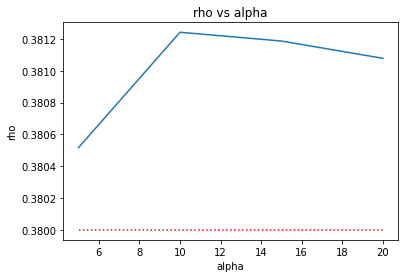

In [55]:
fig, ax = plt.subplots()
ax.set(xlabel='alpha', ylabel='rho', title='rho vs alpha')
ax.plot(alphas, results)
ax.hlines(0.38, 5, 20, colors='red', linestyles='dotted', label='ppmi-lsa')
plt.show()

From Faruqui et al.'s paper, retrofitting should've given at least ~0.03 points improvement in the score. We tried more experiments to attempt to reproduce this order of magnitude of improvement. We noticed that figure 2 shows how larger vector length gave better rho. Previously we reduced our dimension to k=100 since this was optimal at that point of the pipeline. However, perhaps a longer vector will lead to improvements (via retrofitting) that outweigh its suboptimality (via LSA). Therefore, we tried k=200 and k=300 with the best alpha value so far, alpha=10. We even tried apply PPMI -> Retrofitting directly, essentially preserving a length 6000 vector.

In [ ]:
ppmi_lsa_200 = ppmi_lsa_model(k=200)
wn_index_edges_200 = convert_edges_to_indices(wn_edges, ppmi_lsa_200)
wn_retro_200 = Retrofitter(alpha=lambda x: 10, verbose=True)
retro_df_200 = wn_retro_200.fit(ppmi_lsa_200, wn_index_edges_200)
evaluate(retro_df_200)

# directly pmi -> retrofit
# ppmi = ppmi_model()
# print(ppmi.shape)
# wn_edges = get_wordnet_edges()
# wn_index_edges = convert_edges_to_indices(wn_edges, ppmi)
# wn_retro = Retrofitter(verbose=True)
# retro_df = wn_retro.fit(ppmi, wn_index_edges)
# evaluate(retro_df) # 0.2908358495266217

Summary:

| k | alpha | score |
| -- | -- | -- |
| 100 | 1 | 0.3526855467031869 |
| 100 | 5 | 0.38051751210397267 |
| 100 | 10 | 0.38051751210397267 |
| 100 | 15 | 0.3811872428068117 |
| 100 | 20 | 0.38107864472426806 |
| 200 | 10 | 0.3798859630483975 |
| 300 | 10 | 0.37010577937481365 |
| n/a | 1 | 0.2908358495266217 |

(k=n/a is applying PPMI->Retrofitting directly.) Comparing k=100,200,300 with alpha=10, we see that longer vectors actually produced worse scores on our relatedness dataset. Similarly, comparing k=100 and k=n/a (essentially k=6000) with alpha=1, the score was considerably worse with the longer vector.

<h1>GloVe</h1>

We try a second method altogether, applying GloVe to a raw count matrix. The summary is that all our GloVe models performed abysmally, hovering around rho=0 and even slightly negative. Changing the max_iters did not seem to help. 

Chris mentioned in a forum answer that GloVe is sensitive to the vocab size/dimensions of the matrix, so we tried larger values of embed_dim. Generally, it seemed like larger embed_dim resulted in a higher score, but the score was still ~0. We also noticed that only the model with embed_dim=6000 produced reasonable vsm.neighbors(), although these were still not as good as the neighbors previously seen for PPMI/LSA. For the other models, the nearest neighbors were often unrelated words.

We also noticed that the error at the end of the GloVe process was much ~2-4x larger than that of the error in `vsm_02_dimreduce.ipynb`. The difference was that the other notebook used the yelp dataset. We evaluated the GloVe model on the yelp dataset. While the rho value was better than the value for the corresponding gigaword model, the result was still ~0.

In [66]:
from torch_glove import TorchGloVe

In [73]:
glove_model = TorchGloVe(max_iter=100, embed_dim=6000)
glove_df = glove_model.fit(count_df)
evaluate(glove_df)

Finished epoch 100 of 100; error is 2066223.5375

0.020208282263670295


0.020208282263670295

In [74]:
# neighbors finally look reasonable, with embed_dim=6000
vsm.neighbors('superb', glove_df).head()

superb        0.000000
brilliant     0.157920
impressive    0.166645
classic       0.181595
memorable     0.183558
dtype: float64

In [76]:
# sanity check if I can reproduce ref notebook results with yelp5
# resulting error = 1634338.84375; similar to ref notebook
# score is still pretty bad: -0.044
# however, better score than giga20
yelp5_df = pd.read_csv(os.path.join(VSM_HOME, 'yelp_window5-scaled.csv.gz'), index_col=0)
gloveyelp5_model = TorchGloVe(max_iter=100)
gloveyelp5_df = gloveyelp5_model.fit(yelp5_df)
evaluate(gloveyelp5_df)

Finished epoch 100 of 100; error is 1634338.84375

-0.04385115275952578


-0.04385115275952578

Summary of results

| vsm | dim | iters | error (rounded) | score (rounded) |
| --- | --- | --- | --- | --- |
| giga20 | 100 | 100 | 5350000 | -0.2 |
| giga20 | 100 | 300 | 4850000 | -0.19 |
| giga20 | 1000 | 100 | 4610000 | -0.175 | 
| giga20 | 6000 | 100 | 2070000 | 0.020 |
| yelp5 | 100 | 100 | 1630000 | -0.044 |

This concludes the experiments with our two methods, the PPMI-LSA-Retrofitting pipeline, and GloVe.

The highest score obtained from these experiments was 0.381.